## 资产选择

轮动资产选择黄金(ETF基金:518880)，纳指(ETF基金:513100)，创业板(ETF基金:159915)和红利(ETF基金:510880)。

黄金(ETF基金:518880)：  
黄金是一种避险资产，通常在经济不稳定或通货膨胀高企时表现较好。  
它的价格与股票和其他金融资产的表现通常存在负相关关系，因此可以用来对冲股票市场风险。  
黄金还被认为是一种通胀对冲资产，因为它的价格通常会在通货膨胀上升时上涨。

纳指(ETF基金:513100)：  
纳斯达克指数代表了美国科技股市场的表现。  
科技股通常具有高增长性和高估值，是投资组合中增长部分的重要组成部分。  
与其他股票市场（如沪深300）相比，纳斯达克指数的波动性通常更高。  
因此，它可以通过与其他股票市场的组合来实现资产组合的多样化。

创业板(ETF基金:159915)：  
创业板指数代表了中国创新型企业的表现。  
创业板股票通常具有高估值和高风险，但也具有高增长潜力。  
与沪深300等传统股票市场相比，创业板通常更具有成长性和波动性。  
因此，它可以用来增加投资组合的成长性和风险。

红利(ETF基金:510880)：  
红利以A 股中高现金股息率，分红稳定、具有一定规模及流动性的 50 只股票组成，  
采用股息率作为权重分配依据，以反映沪市 A 股市场高红利股票的整体表现。  
红利与高成长的创业板分属不同赛道，A股内拥挤度相对较低。

黄金、纳指、创业板和红利代表了不同类型、风格和市场的资产，它们之间具有一定的互补性。  
通过将这些资产组合在一起，可以实现投资组合的多样化和风险分散。在选择资产时，需要考虑  
到资产的特性和风险收益特征，以及投资者的风险偏好和目标。

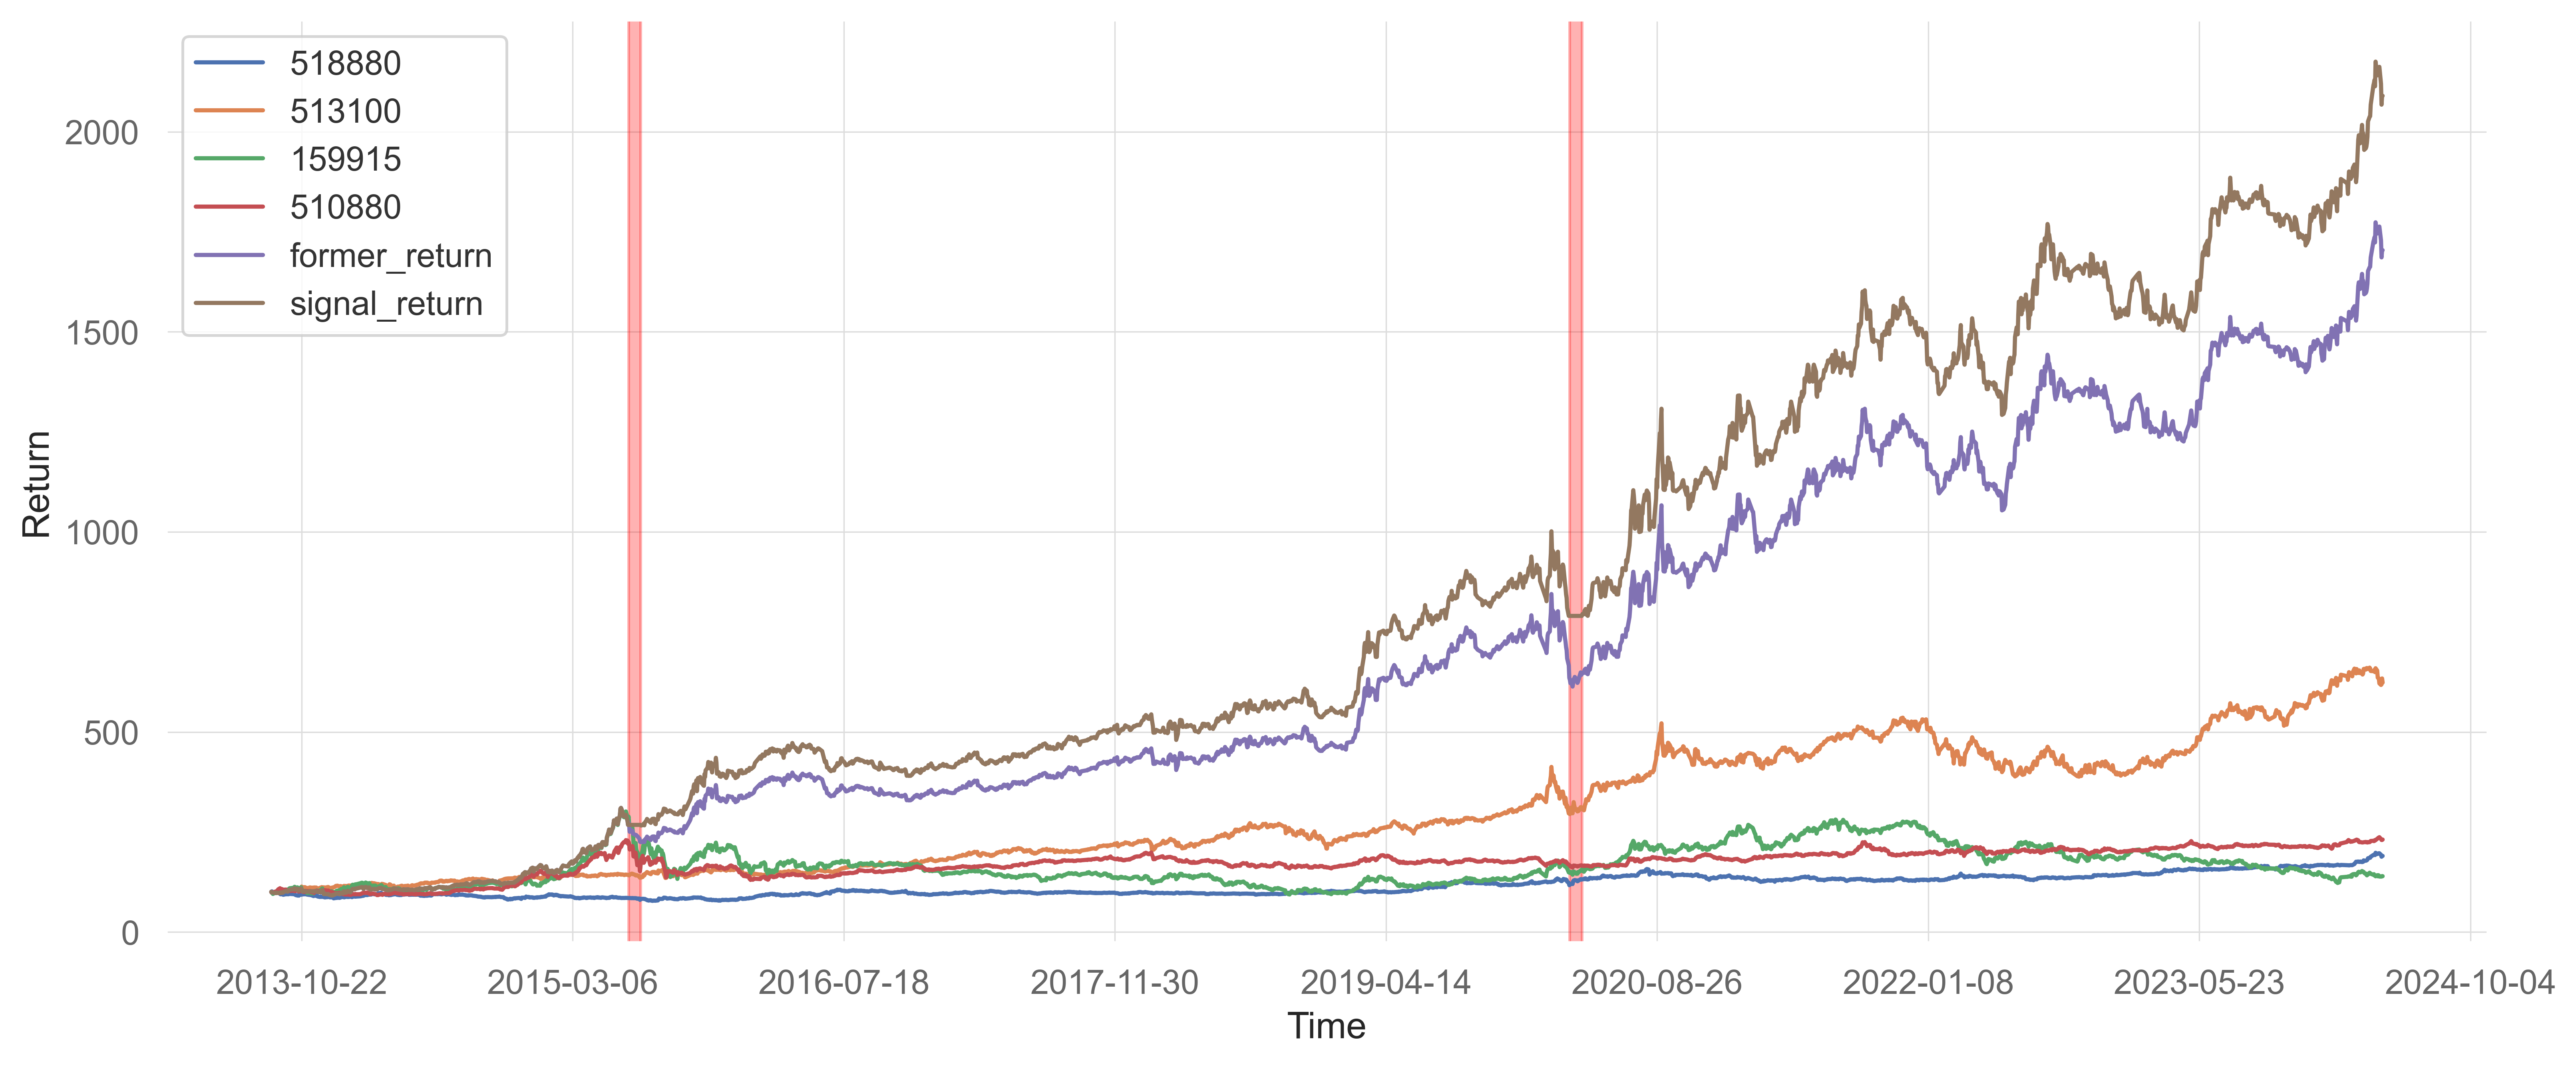

累计收益率：2089


In [22]:
import warnings
warnings.filterwarnings('ignore')
import time
import akshare as ak
import numpy as np
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

def stop_loss(input_list, window_size, threshold, stop_period):
    for i in range(len(input_list)):
        if i >= window_size:
            window_sum = sum(input_list[i+1-window_size:i+1])
            if window_sum < threshold:
                input_list.loc[input_list.index[i+1:i+1+stop_period]] = 0
    return input_list

def back_test(window_size, threshold, stop_period):

    etf_data = {}
    etf_symbols = ['518880', '513100', '159915', '510880']
    window = 21

    # 利用akshare获取 ETF 历史数据, 未指定起止日期，默认获取到今日的数据
    for symbol in etf_symbols:
        etf_df = ak.fund_etf_hist_em(symbol=symbol, period="daily", adjust='hfq')[['日期', '收盘']] \
                .rename(columns={'日期': 'date', '收盘': symbol}).set_index('date')
        etf_data[symbol] = etf_df

    # 合并数据并对齐
    data = pd.concat(list(etf_data.values()), axis=1).dropna()
    data.index = pd.to_datetime(data.index)

    # 计算每日涨跌幅和滚动收益率
    for symbol in etf_symbols:
        column_name = f"{symbol}"
        data[f"{column_name}_day_return"] = data[column_name].rolling(2).apply(lambda x: x[-1]/x[0]-1)
        data[f"{column_name}_return"] = data[column_name].rolling(window=window).apply(lambda x: x[-1]/x[0]-1)
        data[f"{column_name}_ma"] = data[column_name].rolling(window=window).mean()

    # 去掉缺失值
    data = data.dropna()

    data['signal'] = data[[f"{symbol}_return" for symbol in etf_symbols]].idxmax(axis=1).str.split('_').str[0]
    data['signal'] = data['signal'].shift(1)
    data = data.dropna()
    data['signal_day_return'] = data.apply(lambda row: row[f'{row["signal"]}_day_return'], axis=1)
    signal_day_return = data['signal_day_return'].copy()
    data['stop_loss_day_return'] = stop_loss(signal_day_return, window_size, threshold, stop_period)
    data["signal_return"] = np.cumprod(data['stop_loss_day_return'] + 1) * 100
    data['former_return'] = np.cumprod(data['signal_day_return'] + 1) * 100

    # 计算累计收益率
    for symbol in etf_symbols:
        column_name = f"{symbol}_return"
        data[column_name] = 100 * data[f"{symbol}"] / data[f"{symbol}"].values[0]

    # 绘制曲线图
    fig, ax = plt.subplots(figsize=(15, 6), dpi=500)
    ax.set_xlabel('Time')
    ax.set_ylabel('Return')

    for symbol in etf_symbols:
        column_name = f"{symbol}_return"
        ax.plot(data[column_name].index, data[column_name].values)

    ax.plot(data["former_return"].index, data["former_return"].values)
    ax.plot(data["signal_return"].index, data["signal_return"].values)
    ax.legend(etf_symbols + ["former_return", "signal_return"])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(500))

    # 标记连续为0的段
    start = None
    length = 0  # 用于计数连续0的长度
    for i, value in enumerate(data['stop_loss_day_return']):
        if value == 0:
            if start is None:
                start = i  # 记录连续0开始的位置
            length += 1  # 增加连续0的计数
        else:
            if start is not None and length >= 10:
                ax.axvspan(data.index[start], data.index[i-1], color='red', alpha=0.3)  # 使用红色区块标记连续为0的区间
            start = None  # 重置开始位置
            length = 0  # 重置长度计数
    if start is not None and length >= 2:  # 确保最后一个连续为0的段也被标记
        ax.axvspan(data.index[start], data.index[len(data)-1], color='red', alpha=0.3)

    plt.show()

    # 计算策略表现指标
    result = {}
    for symbol in etf_symbols + ["former", "signal",]:
        column_name = f"{symbol}_return"
        result[column_name] = []
        for stat in ["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"]:
            r = getattr(qs.stats, stat)(data[column_name])
            result[column_name].append(r)

    result = pd.DataFrame(result, index=["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"])

    return result, data["signal_return"].values[-1]

result, last = back_test(8, -0.12, 15)
print(f'累计收益率：{int(last)}')

## 风险管理

止损信号：每日计算过去n日收益率（含计算当日），若过去n日收益率低于s，清仓止损，并m天不开仓。

对参数 n,s,m 进行敏感度分析

In [27]:
# 止损参数敏感度分析

def stop_loss(input_list, window_size, threshold, stop_period):
    for i in range(len(input_list)):
        if i >= window_size:
            window_sum = sum(input_list[i+1-window_size:i+1])
            if window_sum < threshold:
                input_list.loc[input_list.index[i+1:i+1+stop_period]] = 0
    return input_list


def total_return(window_sizes, thresholds, stop_periods):
    etf_data = {}
    total_returns = []
    etf_symbols = ['518880', '513100', '159915', '510880']
    window = 21

    # 获取 ETF 历史数据
    for symbol in etf_symbols:
        etf_df = ak.fund_etf_hist_em(symbol=symbol, period="daily", adjust='hfq')[['日期', '收盘']] \
            .rename(columns={'日期': 'date', '收盘': symbol}).set_index('date')
        etf_data[symbol] = etf_df

    # 合并数据并对齐
    data = pd.concat(list(etf_data.values()), axis=1).dropna()
    data.index = pd.to_datetime(data.index)

    # 计算每日涨跌幅和滚动收益率
    for symbol in etf_symbols:
        column_name = f"{symbol}"
        data[f"{column_name}_day_return"] = data[column_name].rolling(2).apply(lambda x: x[-1] / x[0] - 1)
        data[f"{column_name}_return"] = data[column_name].rolling(window=window).apply(lambda x: x[-1] / x[0] - 1)
        data[f"{column_name}_ma"] = data[column_name].rolling(window=window).mean()

    # 去掉缺失值
    data = data.dropna()

    data['signal'] = data[[f"{symbol}_return" for symbol in etf_symbols]].idxmax(axis=1).str.split('_').str[0]
    data['signal'] = data['signal'].shift(1)
    data = data.dropna()
    data['signal_day_return'] = data.apply(lambda row: row[f'{row["signal"]}_day_return'], axis=1)

    for stop_period in stop_periods:
        for window_size in window_sizes:
            for threshold in thresholds:
                signal_day_return = data['signal_day_return'].copy()
                data['stop_loss_day_return'] = stop_loss(signal_day_return, window_size, threshold, stop_period)
                data["signal_return"] = (np.cumprod(data['stop_loss_day_return'] + 1) * 100)
                total_returns.append(data["signal_return"][-1])

    matrix_data = np.array(total_returns).reshape(len(stop_periods), len(window_sizes), len(thresholds))
    return matrix_data


if __name__ == '__main__':
    start_time = time.time()

    window_sizes = [4, 5, 6, 7, 8, 9, 10]
    thresholds = np.arange(-0.02, -0.141, -0.02).tolist()
    thresholds = [round(x,2) for x in thresholds]
    stop_periods = list(range(6,21))
    matrix_data = total_return(window_sizes, thresholds, stop_periods).astype(int)

    # 绘制多个二维热力图来表示三维数据的不同维度
    fig, axes = plt.subplots(5, 3, figsize=(15,15), dpi=800)

    for i, data in enumerate(matrix_data):
        row = i % 5
        col = i // 5
        ax = axes[row, col]
        sns.heatmap(data.T, ax=ax, xticklabels=window_sizes, yticklabels=thresholds, cmap="coolwarm", annot=False)
        ax.set_title(f"Stop {stop_periods[i]} days")

    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    
    print("代码执行时间：", execution_time, "秒")

## 获取调仓信息

In [1]:
def get_position():
    '''
    获取当天持仓信息
    '''
    etf_data = {}
    etf_symbols = ['518880', '513100', '159915', '510880']
    window = 21

    # 获取 ETF 历史数据
    for symbol in etf_symbols:
        etf_df = ak.fund_etf_hist_em(symbol=symbol, period="daily", adjust='hfq')[['日期', '收盘']] \
                .rename(columns={'日期': 'date', '收盘': symbol}).set_index('date')
        etf_data[symbol] = etf_df

    # 合并数据并对齐
    data = pd.concat(list(etf_data.values()), axis=1).dropna()
    data.index = pd.to_datetime(data.index)

    # 计算每日涨跌幅和滚动收益率
    for symbol in etf_symbols:
        column_name = f"{symbol}"
        data[f"{column_name}_day_return"] = data[column_name].rolling(2).apply(lambda x: x[-1]/x[0]-1)
        data[f"{column_name}_return"] = data[column_name].rolling(window=window).apply(lambda x: x[-1]/x[0]-1)
        data[f"{column_name}_ma"] = data[column_name].rolling(window=window).mean()

    # 去掉缺失值
    data = data.dropna()

    data['signal'] = data[[f"{symbol}_return" for symbol in etf_symbols]].idxmax(axis=1).str.split('_').str[0]
    data['signal'] = data['signal'].shift(1)
    data = data.dropna()
    data['signal_day_return'] = data.apply(lambda row: row[f'{row["signal"]}_day_return'], axis=1)
    signal_day_return = data['signal_day_return'].copy()
    data['stop_loss_day_return'] = stop_loss(signal_day_return, 8, -0.10, 8)
    
    if data['stop_loss_day_return'][:8].sum() > -0.10:
        return data['signal'][-1]
    else:
        return "清仓8天"

get_position()

NameError: name 'ak' is not defined